Authors : <br> 
Remy Cordeau <br>
Jules Lagarde <br>
## Question 2 and 3

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


sbird_2d = np.array(mpimg.imread("bird_small.tiff"))
sbird = np.reshape(sbird_2d, (-1, 3))
kmeans = KMeans(n_clusters=10)
kmeans.fit(sbird)
sbird_sd = np.uint8([kmeans.cluster_centers_[l] for l in kmeans.labels_])

sbird_sd_2d = np.reshape(sbird_sd, sbird_2d.shape)
mpimg.imsave("bird_small_sd.tiff", sbird_sd_2d)


In [3]:
sbird_2d.shape

(128, 128, 3)

## Question 4

In [4]:
from sklearn.metrics import mean_squared_error
import math

mse = mean_squared_error(sbird, sbird_sd, squared=True)
psnr = lambda x:10*math.log10((255**2)/x)
print(mse, psnr(mse))

76.10701497395833 29.316556722435692


In [5]:
sbird_sd

array([[220, 178, 110],
       [220, 178, 110],
       [220, 178, 110],
       ...,
       [ 64,  59,  57],
       [ 64,  59,  57],
       [ 25,  26,  24]], dtype=uint8)

In [6]:
def rle_encode(data):
    out=[]
    i=0
    while i<len(data):
        cnt = 1
        while i+1<len(data) and np.array_equal(data[i],data[i+1]):
            cnt+=1
            i+=1
        out.append([data[i], cnt])
        i+=1
    return np.array(out)

def coding_rate(data):
    return (len(data[0])+1)*len(rle_encode(data))/len(data)*len(data[0])


In [7]:
cr1 = coding_rate(sbird_sd)
cr2 = coding_rate(sbird)
print(cr1, cr2)

2.8095703125 11.970703125


## Question 5

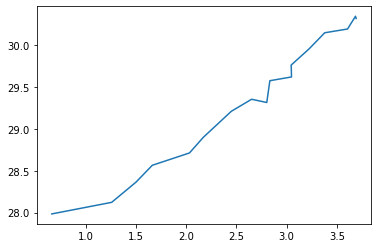

In [8]:
rg = np.arange(2,20,1)
psnr_data = []
cr_data = []
for k in rg:
    km = KMeans(n_clusters=k)
    km.fit(sbird)
    sb_sd = np.uint8([km.cluster_centers_[l] for l in km.labels_])
    psnr_data.append(psnr(mean_squared_error(sbird, sb_sd, squared=True)))
    cr_data.append(coding_rate(sb_sd))
    

plt.plot(cr_data, psnr_data)

We can observe that the curve seems to follow an affine law. (increasing)

## Question 6

The file is composed of a header and body.

The header contains this fields in this order : <br>
32 bit : image witdh <br>
8 bit : number of cluster (k) <br>
24*k : color of each cluster center <br>
8 bit : rle counter size (n) <br>

And the body contains the rle representation using information available in the header.


In [38]:
class BitWriter:
    def __init__(self, file):
        self.f=file
        self.buffer=[]
        self.offset=0
        
    def write(self, v, nb_bit):
        assert ((~(2**nb_bit-1)&v) == 0), "the value v=%s doesn't fit inside %s bits"%(v, nb_bit)
        if self.offset > 0:
            l = 8-self.offset
            mask = (2**l-1)
            if nb_bit < l:
                self.buffer[len(self.buffer)-1] |= (v&mask)<<(l-nb_bit)
            else:
                self.buffer[len(self.buffer)-1] |= v&mask
            v>>=l
        mask = (2**8-1)
        while nb_bit>=8:
            vb = v&mask
            self.buffer.append(vb)
            v>>=8
            nb_bit-=8
        if nb_bit>0:
            self.offset = nb_bit
            self.buffer.append(v<<(8-nb_bit))
        
    def flush(self):
        self.f.write(bytes(np.uint8(self.buffer)))
        self.buffer=[]
        self.offset=0


def write_file(name, image_width, kmean_dict, rle_seq):
    with open(name, "wb") as f:
        length = f.write(bytes(np.uint32([image_width])))
        nb_cluster = len(kmean_dict)
        length += f.write(bytes(np.uint8([nb_cluster])))
        for i in range(nb_cluster):
            length += f.write(bytes(kmean_dict[i]))
        counter_size = math.ceil(math.log2(max([v for _,v in rle_seq])))
        cluster_index_size = math.ceil(math.log2(nb_cluster))
        bw = BitWriter(f)
        for i,c in rle_seq:
            bw.write(i,cluster_index_size)
            bw.write(c,counter_size)
        length += len(bw.buffer)
        bw.flush()
        return length

In [39]:
r = rle_encode(kmeans.labels_)

length = write_file("bird_small.kmean.rle", sbird_2d.shape[0], np.uint8(kmeans.cluster_centers_), r)
